In [ ]:
from google.colab import drive
drive.mount("/content/drive",force_remount=True)

Mounted at /content/drive


In [ ]:
%cd "/content/drive/My Drive/Covid19AI"

/content/drive/My Drive/Covid19AI


In [ ]:
!cp "/content/drive/My Drive/Covid19AI/Jupyter_notebooks/BEASF.py" .

In [ ]:
!cp "/content/drive/My Drive/Covid19AI/Jupyter_notebooks/visualization_tools.py" .

In [ ]:
!pip3 install lime

In [ ]:
import glob, numpy as np, cv2, matplotlib.pyplot as plt, copy, tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras import Model, callbacks as cb, optimizers
from tensorflow.keras.models import load_model, model_from_json
from tensorflow.keras.layers import Dense, Dropout, Lambda, Input, Conv2D, Conv2DTranspose, concatenate, MaxPooling2D
from tensorflow.keras import Model

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from skimage.filters import rank
from skimage.morphology import disk

from BEASF import BEASF
from visualization_tools import GradCAM

# read Data and convert to npy

In [ ]:
def get_images(img_path):
  normal_images = list()
  cap_images = list()
  covid_images = list()
  for img_name in glob.glob(pathname=img_path + '/*'):
    img = load_img(path=img_name, color_mode='grayscale')
    img = img_to_array(img=img, data_format='channels_last')
    if 'COVID' in img_name:
      covid_images.append(img)
    elif 'pneumonia' in img_name:
      cap_images.append(img)
    elif 'normal' in img_name:
      normal_images.append(img)
  normal_images = np.array(normal_images)
  cap_images = np.array(normal_images)
  covid_images = np.array(normal_images)

  normal_labels = [0 for _ in range(len(normal_images))]
  cap_labels = [1 for _ in range(len(cap_images))]
  covid_labels = [2 for _ in range(len(covid_images))]

  X = np.concatenate((covid_images, cap_images, normal_images))
  y = np.array(covid_labels + cap_labels + normal_labels)
  return X,y

In [ ]:
def resize_images_of(X):
    X = np.array([cv2.resize(image, dsize=(320, 320), interpolation=cv2.INTER_CUBIC) for image in X])
    X = np.array([np.expand_dims(a=image, axis=-1) for image in X])
    X = X.astype(dtype=np.uint8)
    return X


def show_random_image_from(X):
    rnd_idx = np.random.choice(a=len(X), size=None)
    plt.imshow(X=X[rnd_idx].squeeze(), cmap='gray')
    plt.axis('off')
    plt.title(label='a random image from the dataset')
    plt.show()


def save_dataset(data, labels):
    print('number of total dataset images:', len(data))
    print('number of total dataset labels:', len(labels))
    print('dataset shape:', data.shape)
    print("export images as npy file? (y/n)")
    if input() == 'y':
        np.save('./cxr_30_samples.npy', arr=data)
        np.save('./cxr_30_labels.npy', arr=labels)
    else:
        print('dataset exportation aborted.')

In [ ]:
!ls

 Additional	      model.ipynb
 BEASF.py	      Pretrained_Model
 covid_cxr_dataset   'Projects progress.gdoc'
 cxr_30_labels.npy    __pycache__
 cxr_30_samples.npy   tmp.h5
 cxr_labels.npy       Untitled0.ipynb
 cxr_samples.npy     'v1.0_eps=099_valAcc=0.9672.hdf5'
 Jupyter_notebooks    visualization_tools.py


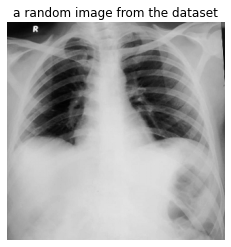

number of total dataset images: 30
number of total dataset labels: 30
dataset shape: (30, 320, 320, 1)
export images as npy file? (y/n)
y


In [ ]:
data_path = '/content/drive/My Drive/Covid19AI/covid_cxr_dataset/test'

X,y = get_images(img_path=data_path)
X = resize_images_of(X=X)
show_random_image_from(X=X)
save_dataset(data=X, labels=y)

# Dataset loading

number of total dataset images: 30
number of total dataset labels: 30
dataset shape: (30, 320, 320, 1)


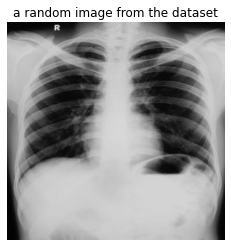

In [ ]:
X = np.load(file='/content/drive/My Drive/Covid19AI/cxr_30_samples.npy')
y = np.load(file='/content/drive/My Drive/Covid19AI/cxr_30_labels.npy')

print('number of total dataset images:', len(X))
print('number of total dataset labels:', len(y))
print('dataset shape:', X.shape)

rnd_idx = np.random.choice(a=len(X), size=None)
plt.imshow(X=X[rnd_idx].squeeze(), cmap='gray')
plt.axis('off')
plt.title(label='a random image from the dataset')
plt.show()

In [ ]:
def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

segmentor = unet(input_size=(320, 320, 1))
# segmentor.summary()
segmentor.load_weights('/content/drive/My Drive/Covid19AI/Pretrained_Model/cxr_reg_weights.hdf5')

In [ ]:
def do_segmentation(images, disk_rad=40, kernel_size=(5, 5), num_iter=3, margin=0):
    equ_images = [rank.equalize(image.squeeze(), selem=disk(radius=disk_rad)) for image in images]
    masks = [segmentor(np.expand_dims(equ_image, axis=[0, -1])) for equ_image in equ_images]
    masks = [cv2.dilate(np.squeeze(mask), kernel=np.ones(kernel_size), iterations=num_iter) for mask in masks]
    images = [image[np.min(np.where(masks[idx]==1)[0]) - margin:np.max(np.where(masks[idx]==1)[0]) + margin, 
                    np.min(np.where(masks[idx]==1)[1]) - margin:np.max(np.where(masks[idx]==1)[1]) + margin]
              for idx, image in enumerate(images)]
    images = [cv2.resize(image, dsize=(320, 320), interpolation=cv2.INTER_CUBIC) for image in images]
    images = [np.expand_dims(image, axis=-1) for image in images]
    return np.array(images)

In [ ]:
%%time
X_segmented = do_segmentation(images=X)

CPU times: user 2.95 s, sys: 767 ms, total: 3.71 s
Wall time: 4 s


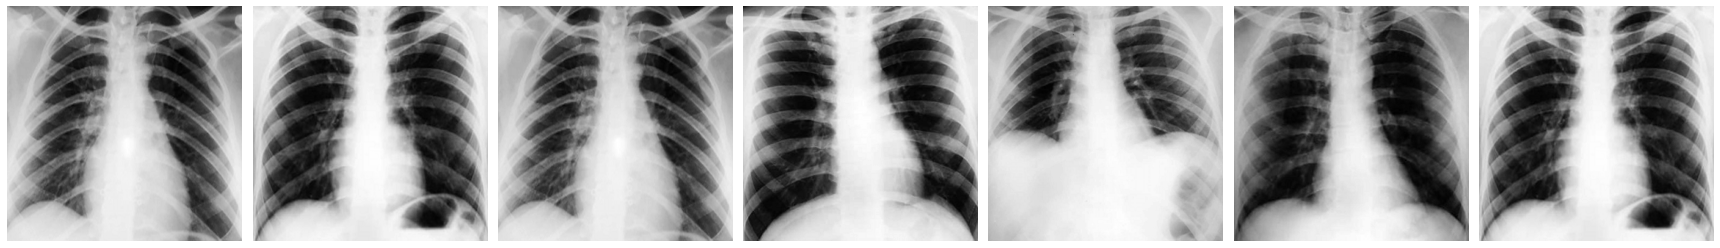

In [ ]:
fig = plt.figure(num=7, figsize=(24, 8))
for i in range(7):
    plt.subplot(1, 7, i+1)
    plt.imshow(X_segmented[np.random.randint(0, len(X_segmented))].squeeze(), cmap='gray')
    plt.axis('off')
fig.tight_layout()
plt.show()

# save the ROI-segmented dataset as npy file
np.save(file='/content/drive/My Drive/Covid19AI/covid_cxr_dataset/cxr_samples_segmented.npy',
        arr=X_segmented)

# Segmentation is completed

# Model



num carious images: 20
num healthy images: 10
number of total dataset images: 30
number of total dataset labels: 30
dataset shape: (30, 320, 320, 3)


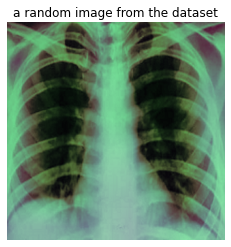

In [ ]:
X = X_segmented
y = y

num_covid_samples = 0
num_normal_samples = 0
for idx, img in enumerate(X):
  if y[idx]:
    num_covid_samples += 1
  else:
    num_normal_samples += 1
print('num carious images:', num_covid_samples)
print('num healthy images:', num_normal_samples)


# manual label smoothing by 0.1 deviation
# y[np.where(y == 0)] = 0.1
# y[np.where(y == 1)] = 0.9

# apply image enhancements and concat with the original image
X_beasf = np.array([BEASF(image=image, gamma=1.5) for image in X])
X_clahe = np.array([cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(image) for image in X])
X_clahe = np.array([np.expand_dims(a=image, axis=-1) for image in X_clahe])
X = np.concatenate((X_beasf, X_clahe, X), axis=-1)

X = np.array([X[idx] / 255. for idx in range(len(X))])

print('number of total dataset images:', len(X))
print('number of total dataset labels:', len(y))
print('dataset shape:', X.shape)

rnd_idx = np.random.choice(a=len(X), size=None)
plt.imshow(X=X[rnd_idx].squeeze(), cmap='gray')
plt.axis('off')
plt.title(label='a random image from the dataset')
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=18)

# # NOTE: sklearn train_test_split function copies the dataset, hence deleting initial data
# # variables will increase RAM space drastically (~ x2)
del X, X_segmented

In [ ]:
# IMPORTANT: applying zoom and brightness at the same time will change image pixel range from
# [0, 1] to [0, 255], hence we need to add rescaling again (despite doing it when importing
# dataset). Otherwise, model will see all validation data (not undergone augmentation) as 
# black images giving a same prediction value for all
augmenter = ImageDataGenerator(rotation_range=170, horizontal_flip=True, vertical_flip=True, 
                               zoom_range=[0.8, 1.5], brightness_range=[0.5, 1.3], rescale=1./255,
                               width_shift_range=0.2, height_shift_range=0.2, fill_mode='constant')

# NOTE: Keras ImageDataGenerator does not keep input image default ratio (as of v2.3.1)
# NOTE: Keras ImageDataGenerator does not resize-and-padd when doing rotation (thus 
# loosing part of the image due to cropping while rotating)
checkpoint = cb.ModelCheckpoint('/content/drive/My Drive/covid_model/eps={epoch:03d}_valLoss={val_loss:.4f}.hdf5',
                                monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
cb_list = [checkpoint]

In [ ]:
X_test = np.array([X_test[idx] / 255. for idx in range(len(X_test))])

In [ ]:
backbone = load_model("/content/drive/My Drive/Covid19AI/Pretrained_Model/CheXNet_model.hdf5")
fc = Dense(units=10, activation='relu', name='fc')(backbone.layers[-2].output)
do = Dropout(rate=0.2, name='dropout')(fc)
output = Dense(units=1, activation='softmax', name='pred')(do)
classifier = Model(inputs=backbone.input, outputs=output)
classifier.trainable = True

fast_adam = optimizers.Adam(learning_rate=0.0001)
smoothened_cce = tf.losses.CategoricalCrossentropy(label_smoothing=0.1)
classifier.compile(optimizer=fast_adam, loss=smoothened_cce, metrics=['accuracy'])
#classifier.summary()
print('num pretrained network layers:', len(classifier.layers))
#del backbone

num pretrained network layers: 431


In [ ]:
!pip3 install keras_lr_finder

Epoch 1/10
5/5 [==============================] - 4s 801ms/step - loss: 0.0000e+00 - accuracy: 0.3333
Epoch 2/10
5/5 [==============================] - 1s 128ms/step - loss: 0.0000e+00 - accuracy: 0.3333
Epoch 3/10
5/5 [==============================] - 1s 128ms/step - loss: 0.0000e+00 - accuracy: 0.3333
Epoch 4/10
5/5 [==============================] - 1s 128ms/step - loss: 0.0000e+00 - accuracy: 0.3333
Epoch 5/10
5/5 [==============================] - 1s 127ms/step - loss: 0.0000e+00 - accuracy: 0.3333
Epoch 6/10
5/5 [==============================] - 1s 128ms/step - loss: 0.0000e+00 - accuracy: 0.3333
Epoch 7/10
5/5 [==============================] - 1s 127ms/step - loss: 0.0000e+00 - accuracy: 0.3333
Epoch 8/10
5/5 [==============================] - 1s 127ms/step - loss: 0.0000e+00 - accuracy: 0.3333
Epoch 9/10
5/5 [==============================] - 1s 128ms/step - loss: 0.0000e+00 - accuracy: 0.3333
Epoch 10/10
5/5 [==============================] - 1s 127ms/step - loss: 0.0000e+0

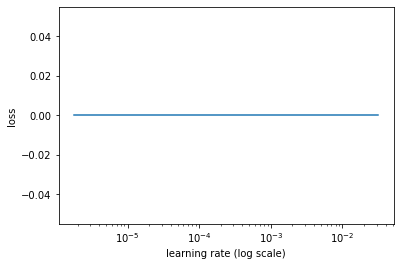

In [ ]:
from keras_lr_finder.lr_finder import LRFinder
lr_finder = LRFinder(model=classifier)
lr_finder.find(x_train=X_train, y_train=y_train, start_lr=0.0000001, end_lr=0.1, batch_size=5, epochs=10)
# best lr is where the plot has highest decreasing slope before the loss jump
lr_finder.plot_loss()
# lr_finder.plot_loss_change(sma=5, n_skip_beginning=5, n_skip_end=5, y_lim=(-0.05, 0.05))

class weights are: [1. 1. 1.]
Epoch 1/20
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.2500
Epoch 00001: val_loss improved from inf to 0.00000, saving model to /content/drive/My Drive/covid_model/eps=001_valLoss=0.0000.hdf5
1/1 [==============================] - 3s 3s/step - loss: 0.0000e+00 - accuracy: 0.2500 - val_loss: 0.0000e+00 - val_accuracy: 0.3333
Epoch 2/20
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.1250
Epoch 00002: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 71ms/step - loss: 0.0000e+00 - accuracy: 0.1250 - val_loss: 0.0000e+00 - val_accuracy: 0.3333
Epoch 3/20
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.3750
Epoch 00003: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 76ms/step - loss: 0.0000e+00 - accuracy: 0.3750 - val_loss: 0.0000e+00 - val_accuracy: 0.3333
Epoch 4/20
1/1 [==========================

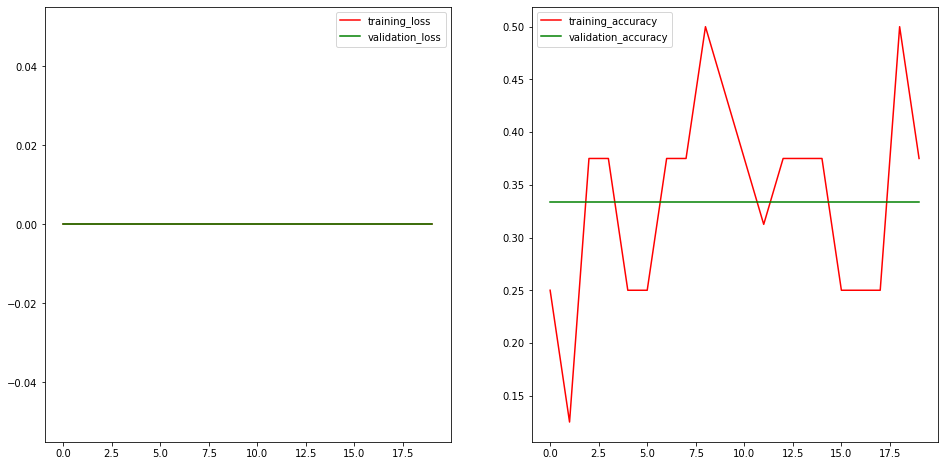

In [ ]:
class_weights = class_weight.compute_class_weight(class_weight='balanced', 
                                                  classes=np.unique(y), y=y).astype('float32')
print('class weights are:', class_weights)
fine_tuning = classifier.fit(augmenter.flow(x=X_train, y=y_train, batch_size=16), 
                             steps_per_epoch=len(X_train)//16,
                             callbacks=cb_list, epochs=20, verbose=1, 
                             validation_data=(X_test, y_test),
                             class_weight=dict({0: class_weights[0], 1: class_weights[1], 
                                                2: class_weights[2]}))

fig = plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(fine_tuning.history['loss'], color='r', label='training_loss')
plt.plot(fine_tuning.history['val_loss'], color='g', label='validation_loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(fine_tuning.history['accuracy'], color='r', label='training_accuracy')
plt.plot(fine_tuning.history['val_accuracy'], color='g', label='validation_accuracy')
plt.legend()
plt.show()
# fig.savefig('/content/drive/My Drive/covid_model/fine_tuning.png')